# Library Import

In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

import warnings

In [84]:
warnings.filterwarnings("ignore")
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드

In [85]:
mp = pd.read_csv('./전처리최종파일/mp_shift.csv').drop('Unnamed: 0', axis=1)
mp.head()

,날짜,지역,관광객,FESTIVAL,기온(°C),습도(%),강수량(mm),코로나인원,holliday,누적확진(명),신규확진(명),shift(1),shift(2),shift(3),shift(4),shift(5)
0,2019-03-01,목포시,77371.0,0.0,9.300000,47.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-03-02,목포시,80479.0,0.0,11.185714,52.428571,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03-03,목포시,66308.0,0.0,10.714286,62.285714,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-03-04,목포시,51879.0,0.0,9.971429,58.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-03-05,목포시,49055.0,0.0,9.671429,66.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [87]:
# params
splits = -5
lr = 0.05
n_estimator = 100
gamma = 0.05

## Data Split

In [88]:
mp_data = mp.drop(['날짜', '지역'], axis=1)
# NA 처리는 linear interpolate 활용 (선형 보간법, forward로)
mp_data = mp_data.interpolate(method='linear', limit_direction='forward')
col_Y = ['관광객']
mp_data = mp_data[:-2]

mp_train = mp_data[:splits]
mp_trainX, mp_trainy = mp_train[mp_train.columns.difference(col_Y)], mp_train[col_Y]
mp_test = mp_data[splits:]
mp_testX, mp_testy = mp_test[mp_test.columns.difference(col_Y)], mp_test[col_Y]

In [89]:
import xgboost as xgb

## Model making

In [90]:
model = xgb.XGBRegressor(booster='gbtree', gamma=0.01, learning_rate=0.07, max_depth=5)
model_tree = xgb.XGBRegressor(booster='gbtree', eval_metric='mae', learning_rate=lr, n_estimators=n_estimator, gamma=gamma)

In [91]:
model.fit(mp_trainX, mp_trainy)
model_tree.fit(mp_trainX, mp_trainy)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae',
             gamma=0.05, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

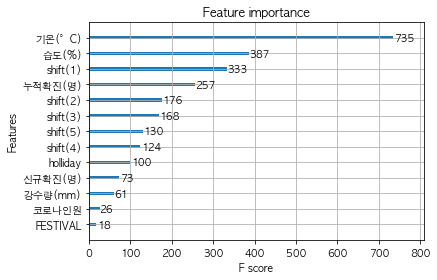

In [92]:
xgb.plot_importance(model_tree)

In [93]:
tree_pred = model_tree.predict(mp_testX)
pred = model.predict(mp_testX)

In [94]:
mae_tree = mean_absolute_error(tree_pred, mp_testy)
mae = mean_absolute_error(pred, mp_testy)

In [95]:
print('tree model precition and real case\n')
print(np.round(tree_pred))
print(np.array(mp_testy).reshape(-1))

print('-'*50)

print('linear model precition and real case\n')
print(np.round(linear_pred))
print(np.array(mp_testy).astype(float).reshape(-1))

print('-'*50)
print(f'tree boosting MAE : {mae_tree}')
print(f'GridSearch boosting MAE : {mae}')

tree model precition and real case

[51947. 51981. 53656. 56968. 73840.]
[51743. 52522. 54323. 62398. 81635.]
--------------------------------------------------
linear model precition and real case

[62606. 63926. 74943. 73862. 60099.]
[51743. 52522. 54323. 62398. 81635.]
--------------------------------------------------
tree boosting MAE : 2927.14765625
GridSearch boosting MAE : 3124.90078125


In [96]:
pred_df = pd.DataFrame(columns=['number', 'tree_pred','linear_pred', 'real'])
pred_df['number'] = [1,2,3,4,5]
pred_df['tree_pred'] = tree_pred
pred_df['GridSearch_pred'] = pred
pred_df['real'] = np.array(mp_testy).astype(float).reshape(-1)

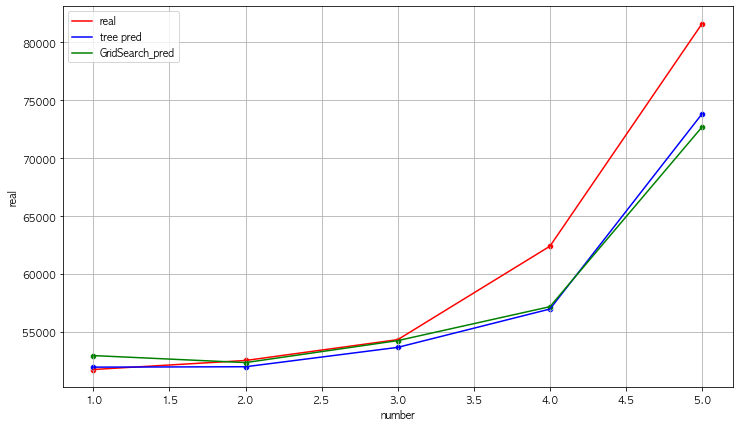

In [97]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data=pred_df,x='number', y='real', color='r')
sns.scatterplot(data=pred_df,x='number', y='real', color='r')
sns.lineplot(data=pred_df,x='number', y='tree_pred', color='b')
sns.scatterplot(data=pred_df,x='number', y='tree_pred', color='b')
sns.lineplot(data=pred_df,x='number', y='GridSearch_pred', color='g')
sns.scatterplot(data=pred_df,x='number', y='GridSearch_pred', color='g')

plt.legend(labels=['real', 'tree pred', 'GridSearch_pred'])
plt.grid()
plt.show()